In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import uproot
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn import BCELoss, Sigmoid
from torch.optim import Adam
from HyPER.models import MPNNs, HyperedgeModel, HyperedgeLoss, EdgeLoss, CombinedLoss
from torchmetrics.classification import BinaryAccuracy
import seaborn as sns
import joblib
import os
os.makedirs("4_Top_results", exist_ok=True)


In [2]:

# Configuration
jet_features = ['Jet.PT', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged', 'Jet.EhadOverEem',
                'Jet.Eta', 'Jet.BTag', 'Jet.Flavor', 'Jet.T', 'Jet.DeltaEta',
                'Jet.DeltaPhi', 'Jet.ChargedEnergyFraction', 'Jet.NeutralEnergyFraction']
lepton_features = ['Electron.PT', 'Electron.Eta', 'Electron.Phi', 'Muon.PT', 'Muon.Eta', 'Muon.Phi']
met_features = ['MissingET.MET', 'MissingET.Phi']
all_features = jet_features + lepton_features + met_features

signal_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root'
# background_file = 'C:/Users/sande/Desktop/project rootfiles/13TeV_BKG_5k.root'
background_file = 'C:/Users/sande/Desktop/ttttsm.root'

tree_name = 'Delphes'
batch_size = 32
delta_r_threshold = 0.9


In [3]:

# Helper functions
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(delta_eta**2 + delta_phi**2)

def normalize_features(x):
    if x.shape[0] == 0:
        return x
    return (x - x.mean(axis=0)) / (x.std(axis=0) + 1e-8)

def convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_thresh=2.0):
    N = x_all.shape[0]
    if N == 0:
        return None

    edge_index_list = []
    edge_attr_list = []
    edge_target_list = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dr = delta_r(eta_all[i], phi_all[i], eta_all[j], phi_all[j])
            edge_index_list.append([i, j])
            edge_attr_list.append([dr])
            edge_target_list.append([1 if dr < delta_r_thresh else 0])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).T
    edge_attr_s = torch.tensor(edge_attr_list, dtype=torch.float)
    edge_attr_t = torch.tensor(edge_target_list, dtype=torch.float)

    hyperedge_list = []
    for j in range(N):
        neighbors = [j]
        for k in range(N):
            if j != k and delta_r(eta_all[j], phi_all[j], eta_all[k], phi_all[k]) < delta_r_thresh:
                neighbors.append(k)
        if len(neighbors) > 1:
            hyperedge_list.append(neighbors)

    if not hyperedge_list:
        return None

    node_indices = np.concatenate(hyperedge_list).astype(np.int64)
    hyperedge_indices = np.repeat(np.arange(len(hyperedge_list)), [len(h) for h in hyperedge_list]).astype(np.int64)
    hyperedge_index = torch.from_numpy(np.stack([node_indices, hyperedge_indices])).long()

    u_s = torch.tensor([[x_all[:, 0].sum(), x_all[:, 1].mean()]], dtype=torch.float)

    data = Data(
        x_s=torch.tensor(x_all, dtype=torch.float),
        u_s=u_s,
        edge_index=edge_index,
        edge_attr_s=edge_attr_s,
        edge_attr_s_batch=torch.zeros(edge_index.shape[1], dtype=torch.long),
        edge_attr_t=edge_attr_t.view(-1, 1),
        edge_index_h=hyperedge_index,
        edge_index_h_batch=torch.zeros(hyperedge_index.shape[1], dtype=torch.long),
        x_t=torch.tensor([label], dtype=torch.float),
        batch=torch.zeros(N, dtype=torch.long)
    )
    return data


In [4]:

def load_data_hyper_format(file_path, label):
    file = uproot.open(file_path)
    tree = file[tree_name]
    events = tree.arrays(all_features, library='np')
    data_list = []

    num_events = len(events[jet_features[0]])
    for i in range(num_events):
        jet_data = [events[feat][i] for feat in jet_features]
        x_jets = np.column_stack(jet_data)
        x_jets = np.nan_to_num(x_jets)
        x_jets = normalize_features(x_jets)

        elec_data = [events[feat][i] for feat in lepton_features[:3]]
        muon_data = [events[feat][i] for feat in lepton_features[3:]]
        x_elec = np.column_stack(elec_data) if len(elec_data[0]) > 0 else np.empty((0, 3))
        x_muon = np.column_stack(muon_data) if len(muon_data[0]) > 0 else np.empty((0, 3))
        x_leptons = np.vstack([x_elec, x_muon])

        if x_leptons.size == 0:
            x_leptons = np.zeros((0, 13))
        elif x_leptons.shape[1] != 13:
            x_leptons = np.pad(x_leptons, ((0, 0), (0, 13 - x_leptons.shape[1])), mode='constant')
        x_leptons = normalize_features(x_leptons)

        met_data = [events[feat][i] for feat in met_features]
        x_met = np.array(met_data).reshape(1, -1)
        x_met = np.nan_to_num(x_met)
        if x_met.shape[1] != 13:
            x_met = np.pad(x_met, ((0, 0), (0, 13 - x_met.shape[1])), mode='constant')
        x_met = normalize_features(x_met)

        x_all = np.vstack([x_jets, x_leptons, x_met])
        eta_all = np.concatenate([
            x_jets[:, 5] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 1] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 1] if x_met.shape[0] > 0 else np.array([])
        ])
        phi_all = np.concatenate([
            x_jets[:, 1] if x_jets.shape[0] > 0 else np.array([]),
            x_leptons[:, 2] if x_leptons.shape[0] > 0 else np.array([]),
            x_met[:, 0] if x_met.shape[0] > 0 else np.array([])
        ])

        data = convert_to_hyper_data(x_all, eta_all, phi_all, label, delta_r_threshold)
        if data:
            data_list.append(data)

    return data_list


In [ ]:
# Load full dataset
signal_data = load_data_hyper_format(signal_file, 1)
background_data = load_data_hyper_format(background_file, 0)
dataset = signal_data + background_data
np.random.shuffle(dataset)
split = int(0.8 * len(dataset))
train_data = dataset[:split]
test_data = dataset[split:]
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# TensorBoard logger
logger = TensorBoardLogger("lightning_logs", name="hypergraph")


In [6]:

# Define LightningModule
class HyPERModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MPNNs(
            node_in_channels=13,
            edge_in_channels=1,
            global_in_channels=2,
            node_out_channels=32,
            edge_out_channels=1,
            global_out_channels=32,
            message_feats=32,
            dropout=0.01,
            activation=Sigmoid(),
            p_out='edge'
        )
        self.hyper = HyperedgeModel(
            node_in_channels=32,
            node_out_channels=1,
            global_in_channels=32,
            message_feats=32,
            dropout=0.01
        )
        self.criterion_edge = BCELoss(reduction='none')
        self.criterion_hyper = BCELoss()
        self.alpha = 0.5
        self.y_true, self.y_score = [], []

    def forward(self, data):
        x, edge_attr, u = self.model(
            data.x_s, data.edge_index, data.edge_attr_s, data.u_s, data.batch
        )
        x_hat, batch_hyper = self.hyper(
            x, u, data.batch, data.edge_index_h, data.edge_index_h_batch, 3
        )
        return x_hat, batch_hyper, edge_attr

    def training_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        loss_hyper = self.criterion_hyper(
            x_event_pred.view(-1), batch.x_t.float().view(-1)
        )
        loss_edge = EdgeLoss(
            edge_attr_prime.view(-1),
            batch.edge_attr_t.view(-1),
            batch.edge_attr_s_batch,
            self.criterion_edge,
            reduction='mean'
        )
        loss = CombinedLoss(loss_edge, loss_hyper, self.alpha, 'mean')
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x_hat, batch_hyper, edge_attr_prime = self.forward(batch)
        x_event_pred = torch.zeros_like(batch.x_t.float())
        for i in range(len(batch.x_t)):
            x_event_pred[i] = x_hat[batch_hyper == i].mean()

        pred_probs = x_event_pred.detach().cpu().numpy()
        true_labels = batch.x_t.detach().cpu().numpy()
        self.y_score.extend(pred_probs)
        self.y_true.extend(true_labels)

        pred_class = (x_event_pred > 0.5).float()
        acc = (pred_class == batch.x_t.float()).float().mean()
        self.log('val_acc_hyper', acc, prog_bar=True)

    def on_validation_epoch_end(self):
        y_true = np.array(self.y_true)
        y_pred = np.array(self.y_score)
        y_pred_class = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_true, y_pred_class)
        prec = precision_score(y_true, y_pred_class)
        rec = recall_score(y_true, y_pred_class)
        f1 = f1_score(y_true, y_pred_class)
        roc = roc_auc_score(y_true, y_pred)

        self.log('val_roc_auc', roc, prog_bar=True, on_epoch=True)
        self.log('val_f1', f1, prog_bar=False, on_epoch=True)
        self.log('val_precision', prec, prog_bar=False, on_epoch=True)
        self.log('val_recall', rec, prog_bar=False, on_epoch=True)

        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, ROC AUC: {roc:.4f}")

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid()
        plt.show()

        cm = confusion_matrix(y_true, y_pred_class)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # row-wise normalization

        sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()

        plt.hist(y_pred[y_true == 1], bins=20, alpha=0.7, label='Signal', color='blue', density=True)
        plt.hist(y_pred[y_true == 0], bins=20, alpha=0.7, label='Background', color='red', density=True)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title('Signal vs Background Probabilities')
        plt.legend()
        plt.grid()
        plt.show()

        joblib.dump((y_true, y_pred), 'results/hyper_model_output.pkl')
        torch.save(self.state_dict(), 'results/hyper_model.pt')

        self.y_true.clear()
        self.y_score.clear()

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_acc_hyper",
                "frequency": 1,
                "strict": True
            },
        }


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 6GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | model           | MPNNs          | 14.0 K | train
1 | hyper           | HyperedgeModel | 8.4 K  | train
2 | criterion_edge  | BCELoss        | 0      | train
3 | criterion_hyper | BCELoss        | 0      | train
-----------------------------------------------------------
22.4 K    Trainable params
0         Non-trainable params
22.4 K    Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Accuracy: 0.3594, Precision: 0.3594, Recall: 1.0000, F1: 0.5287, ROC AUC: 0.3669


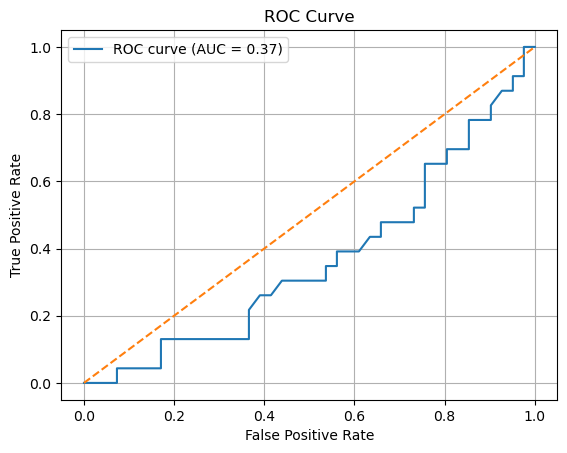

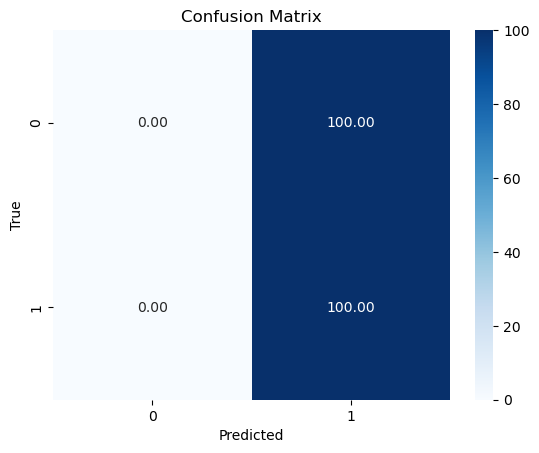

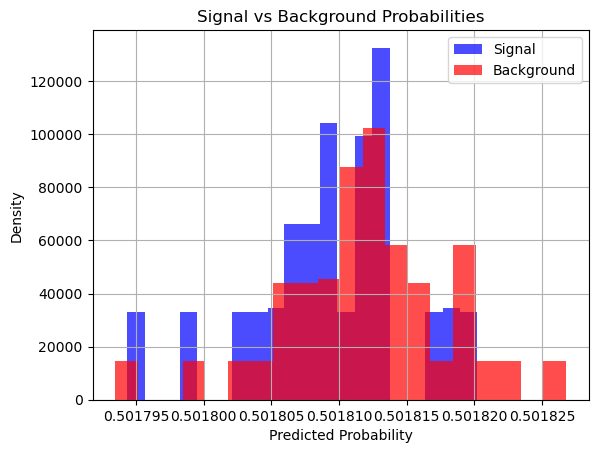

C:\Users\sande\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8725, Precision: 0.8316, Recall: 0.7769, F1: 0.8033, ROC AUC: 0.9334


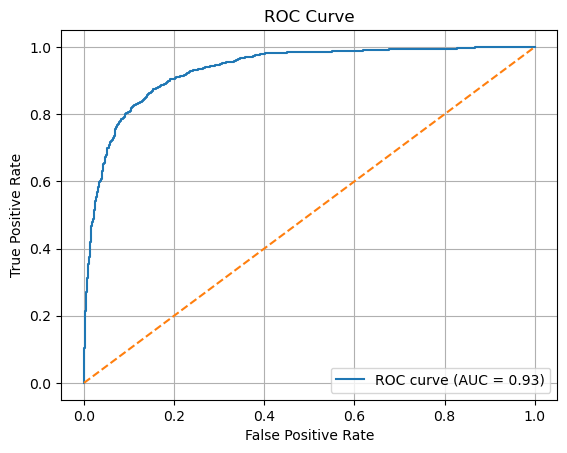

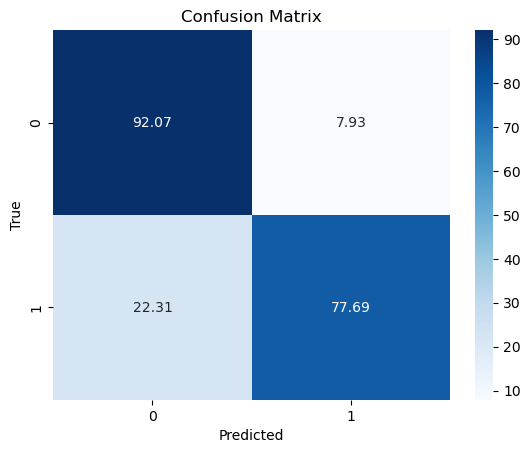

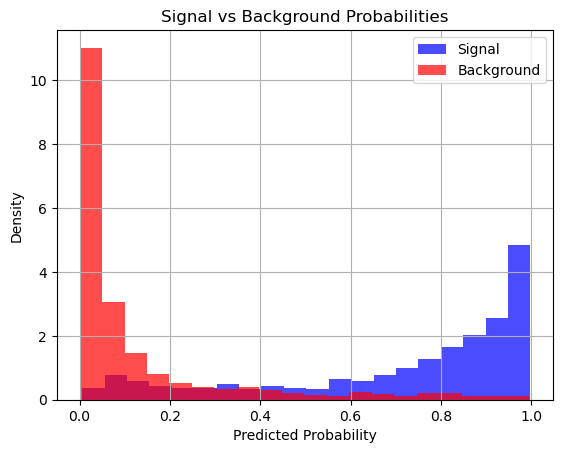

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8682, Precision: 0.7478, Recall: 0.9153, F1: 0.8231, ROC AUC: 0.9502


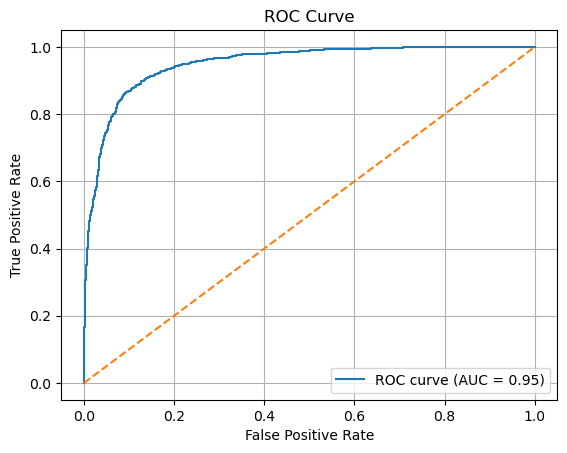

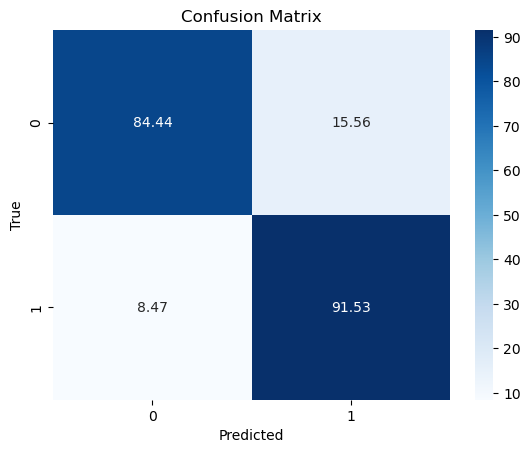

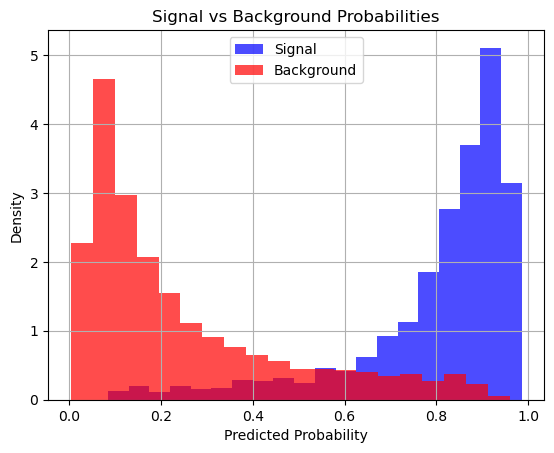

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8935, Precision: 0.8316, Recall: 0.8556, F1: 0.8434, ROC AUC: 0.9516


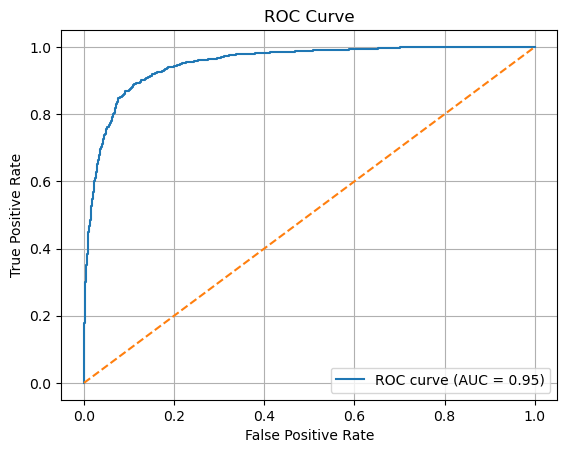

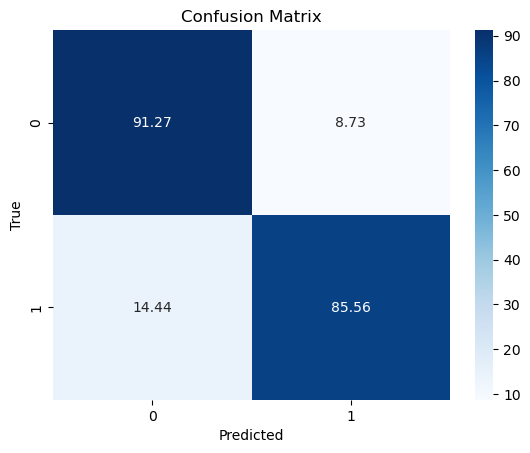

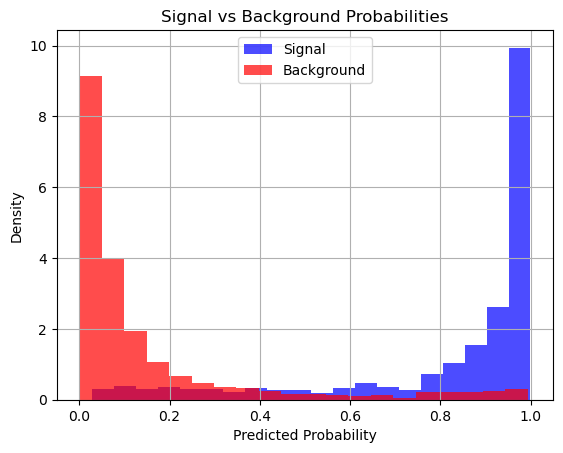

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8868, Precision: 0.7904, Recall: 0.9014, F1: 0.8423, ROC AUC: 0.9537


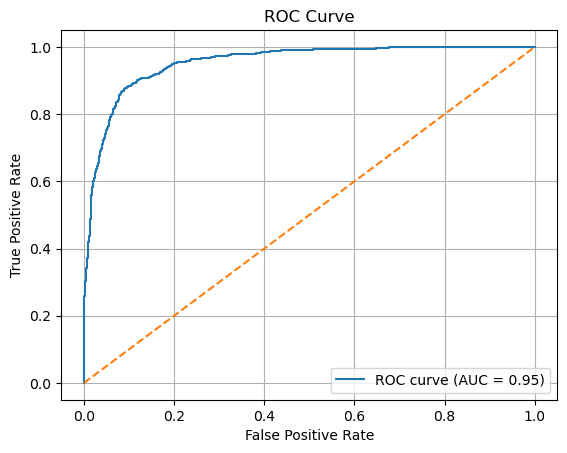

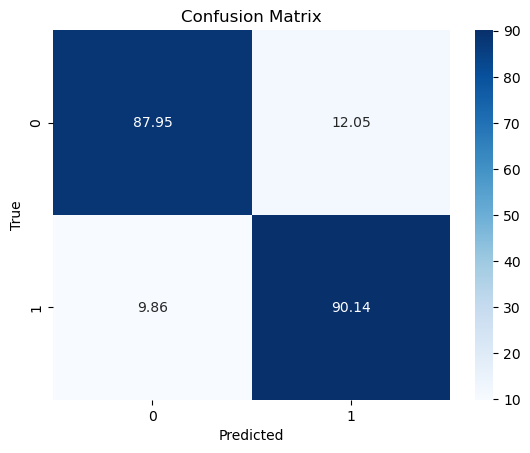

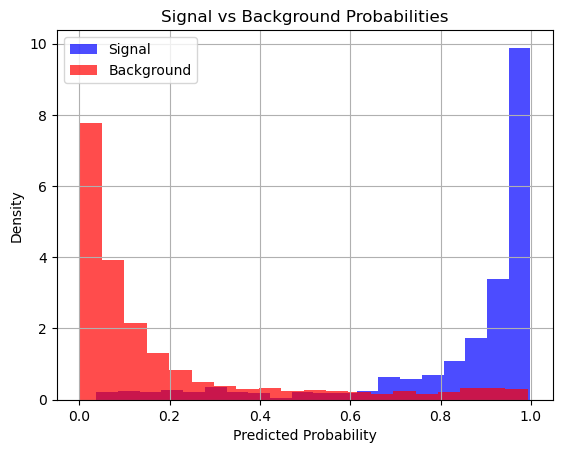

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8962, Precision: 0.8354, Recall: 0.8596, F1: 0.8473, ROC AUC: 0.9543


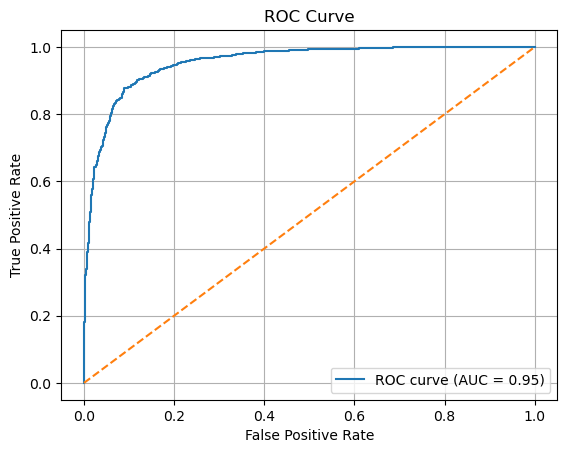

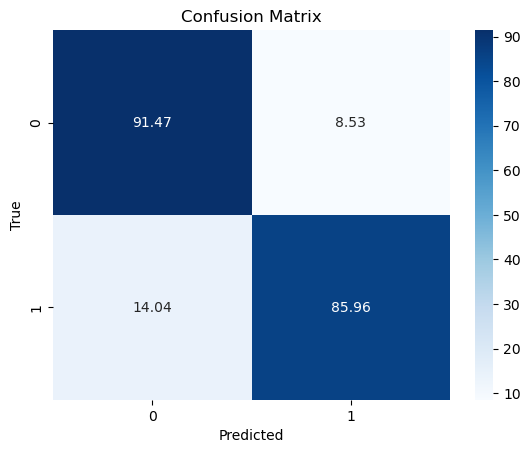

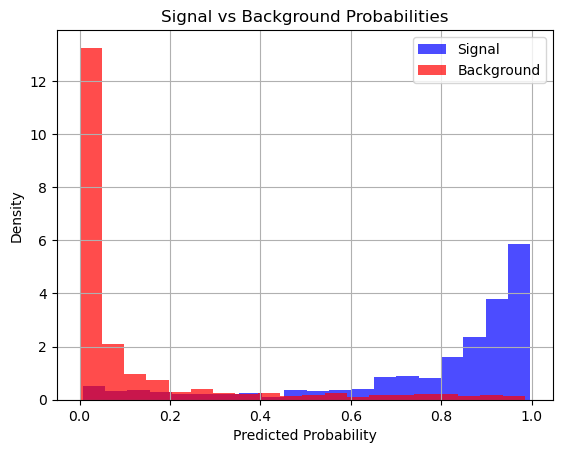

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8868, Precision: 0.8749, Recall: 0.7729, F1: 0.8207, ROC AUC: 0.9549


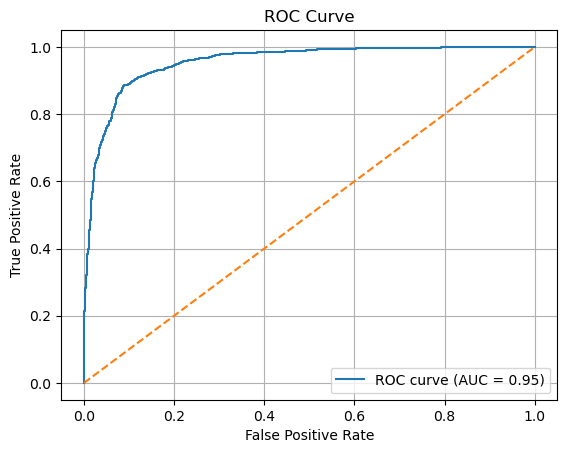

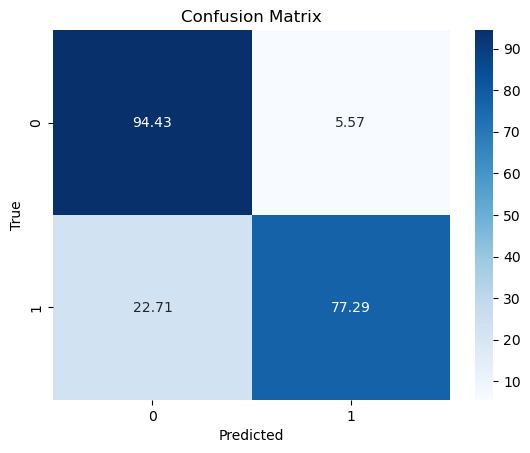

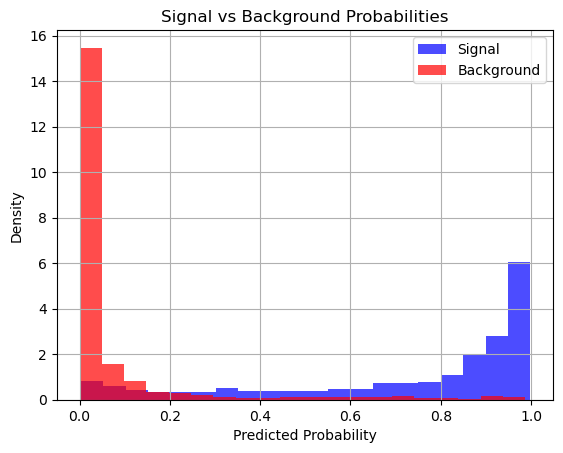

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8959, Precision: 0.8419, Recall: 0.8486, F1: 0.8452, ROC AUC: 0.9551


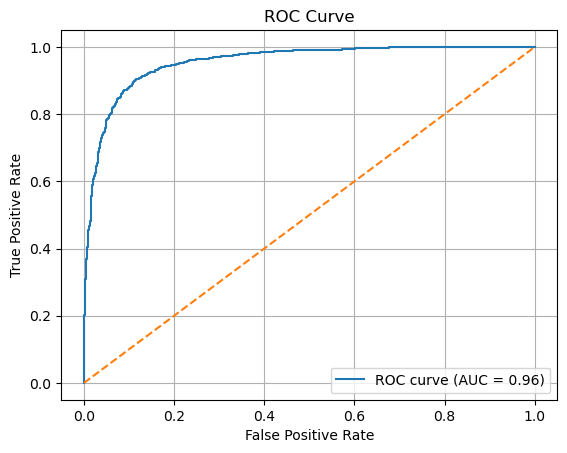

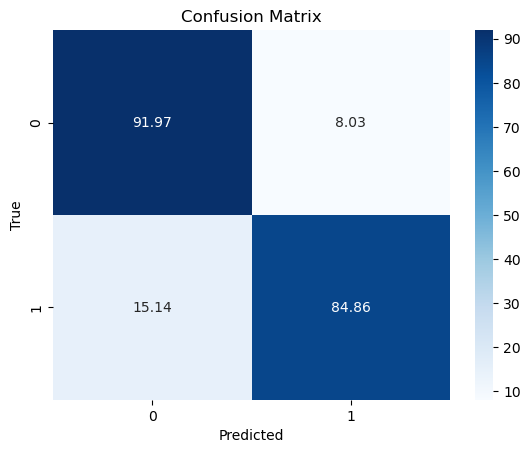

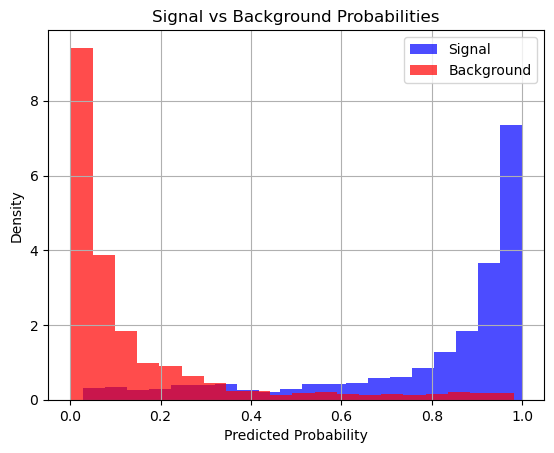

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8652, Precision: 0.9237, Recall: 0.6514, F1: 0.7640, ROC AUC: 0.9559


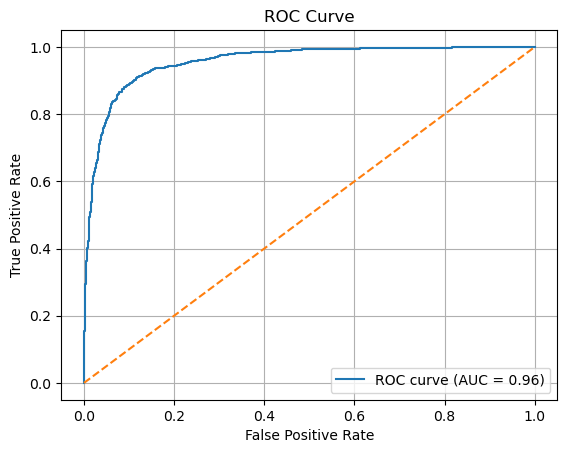

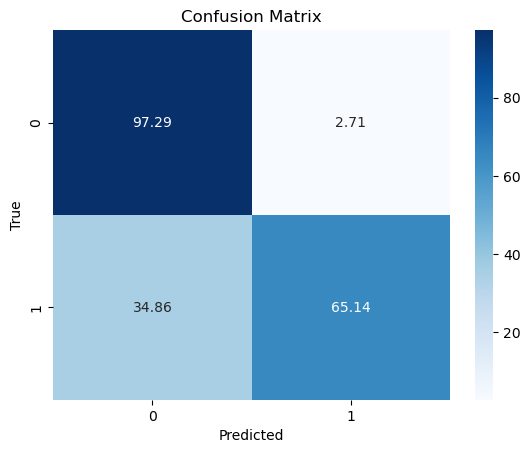

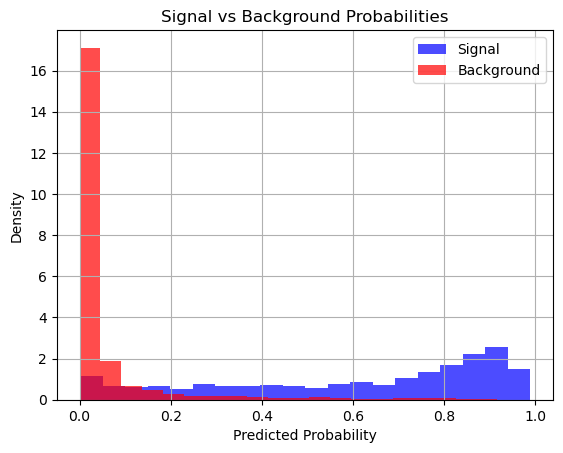

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8955, Precision: 0.8438, Recall: 0.8446, F1: 0.8442, ROC AUC: 0.9555


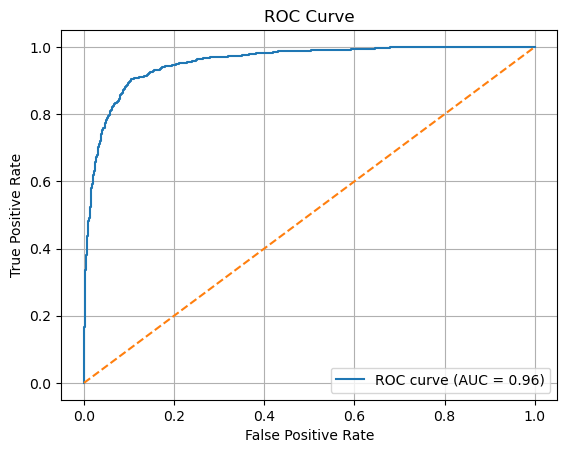

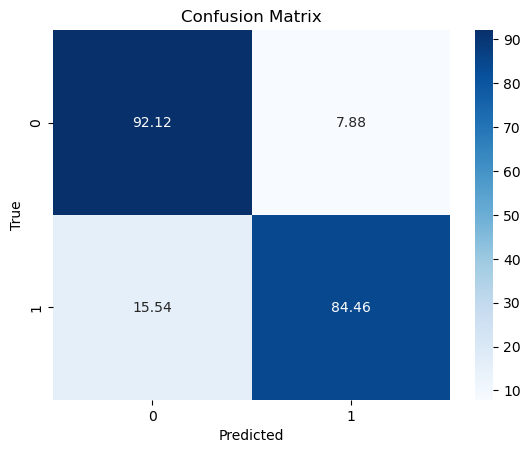

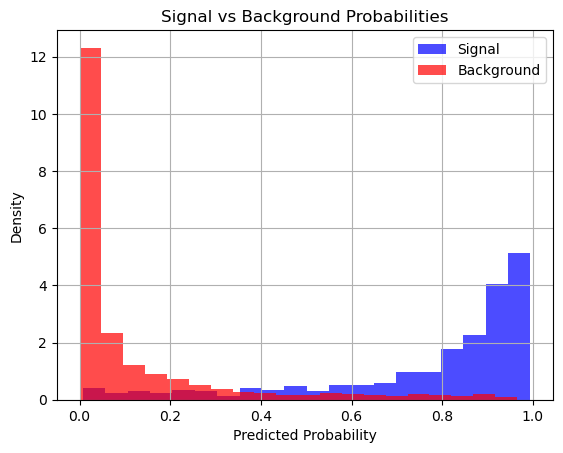

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8969, Precision: 0.8233, Recall: 0.8815, F1: 0.8514, ROC AUC: 0.9558


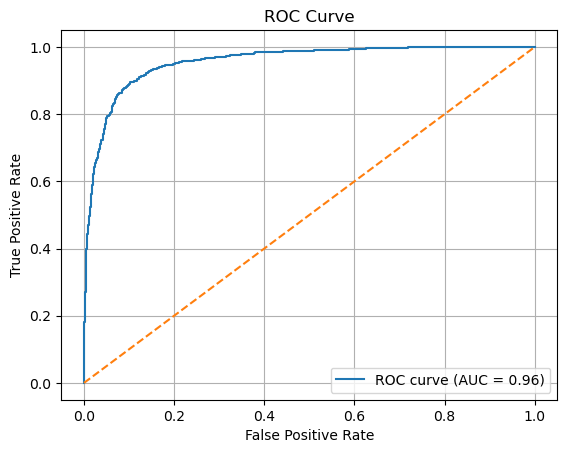

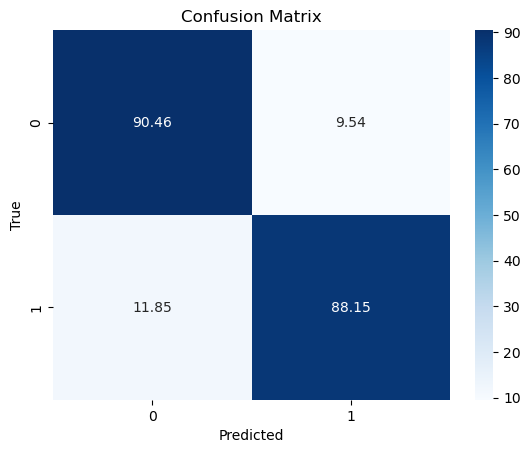

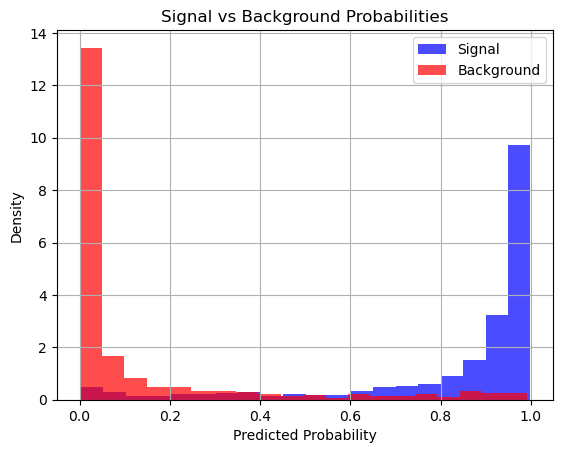

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.9009, Precision: 0.8449, Recall: 0.8625, F1: 0.8536, ROC AUC: 0.9557


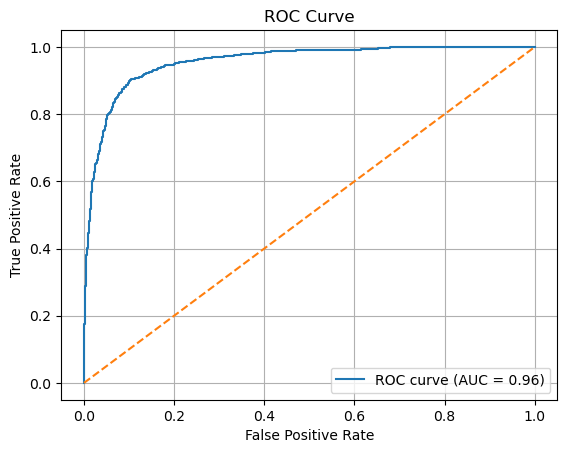

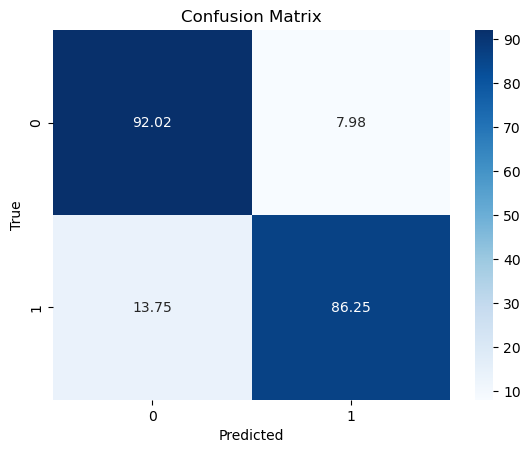

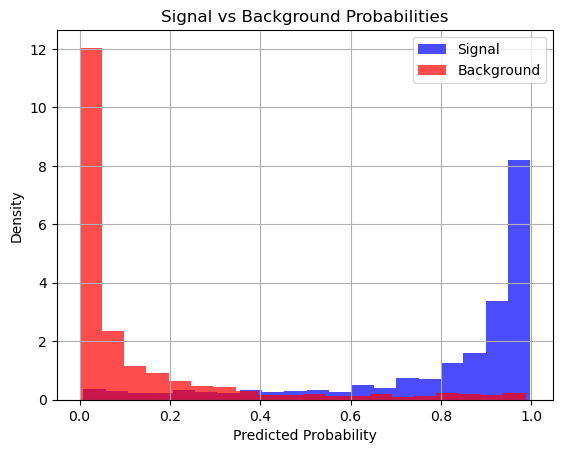

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8868, Precision: 0.7884, Recall: 0.9054, F1: 0.8428, ROC AUC: 0.9552


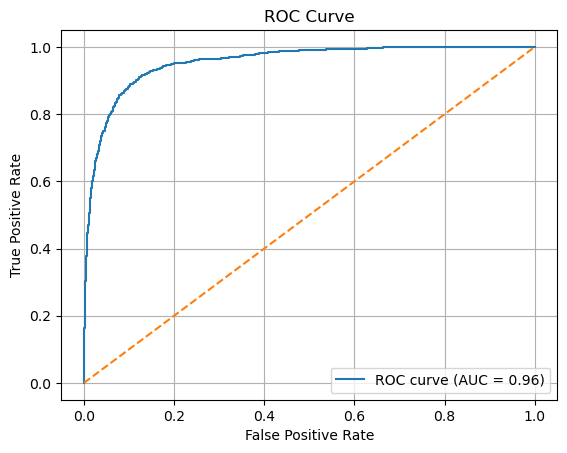

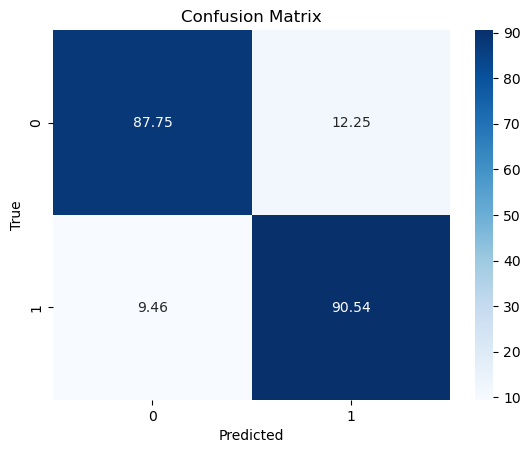

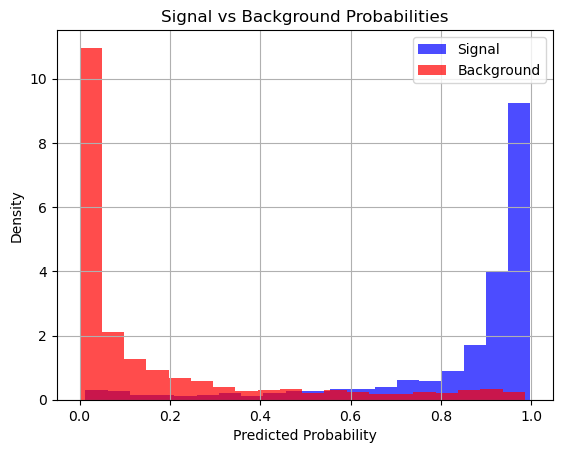

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8999, Precision: 0.8404, Recall: 0.8655, F1: 0.8528, ROC AUC: 0.9566


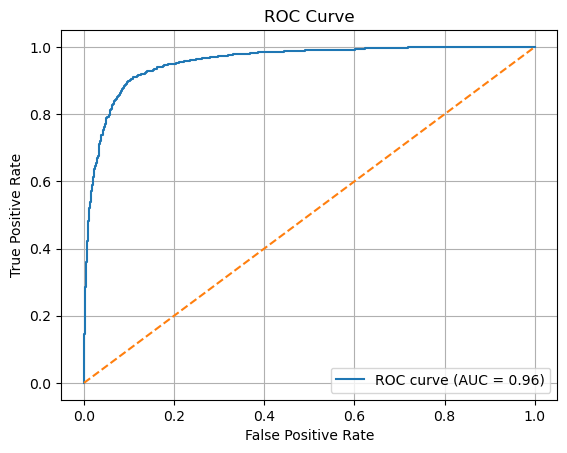

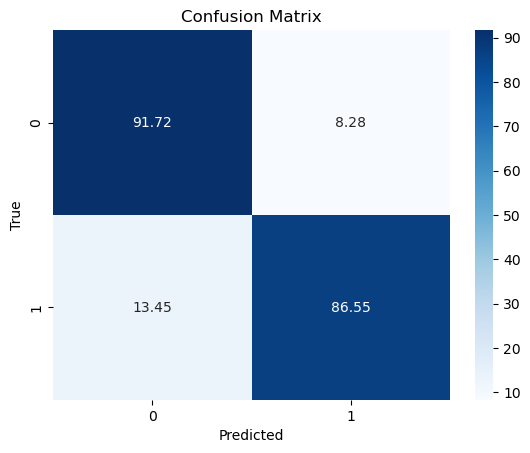

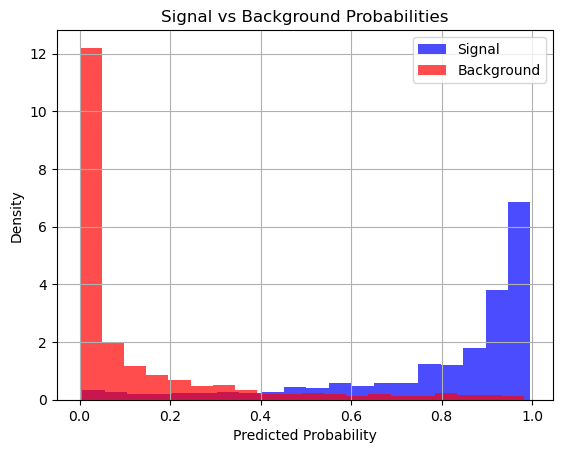

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8982, Precision: 0.8397, Recall: 0.8606, F1: 0.8500, ROC AUC: 0.9570


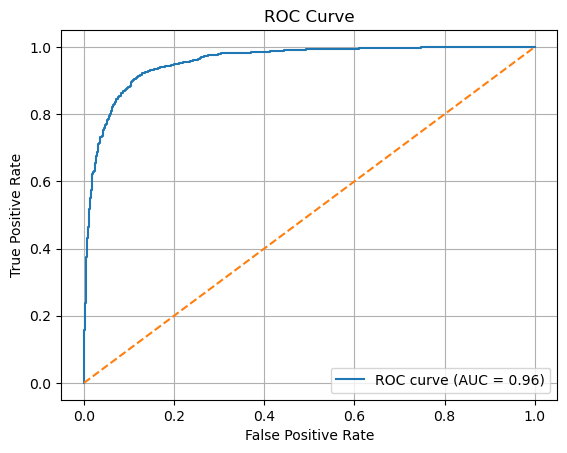

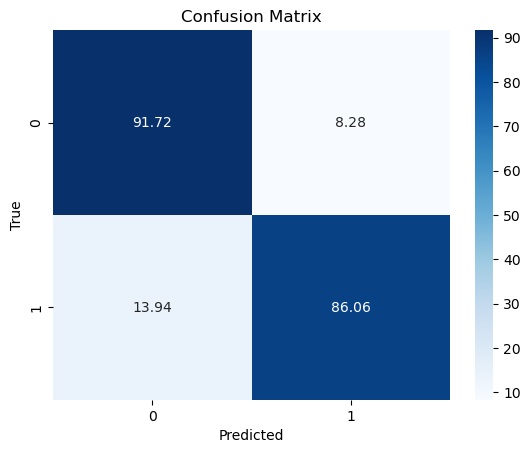

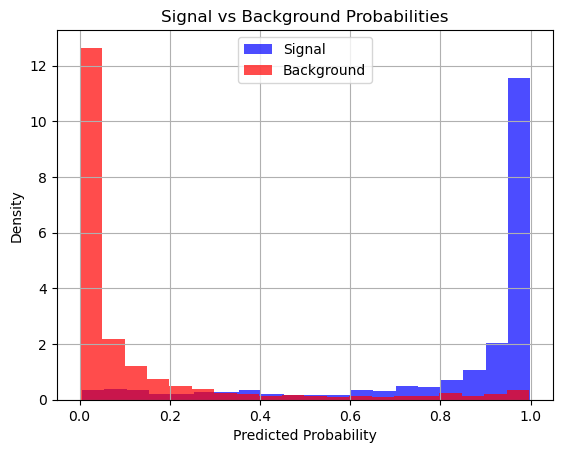

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.9002, Precision: 0.8586, Recall: 0.8406, F1: 0.8495, ROC AUC: 0.9557


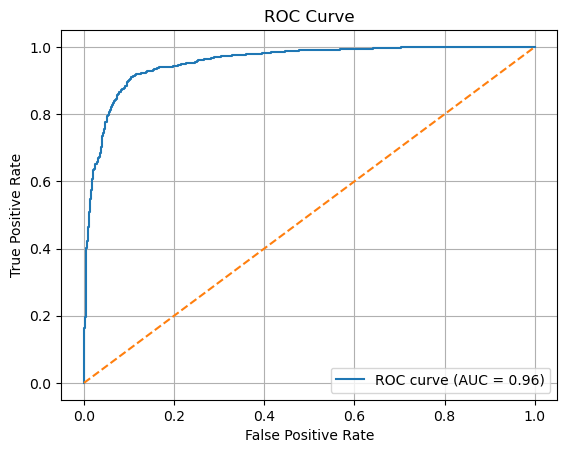

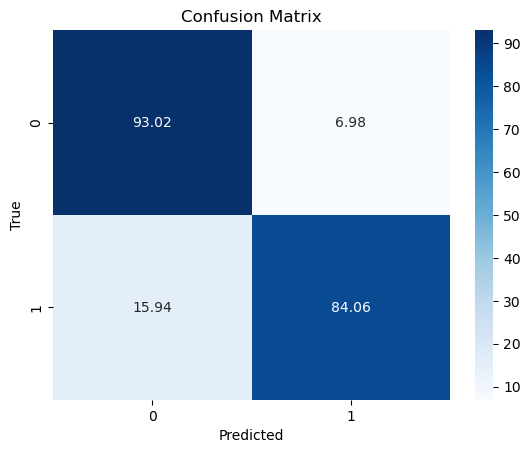

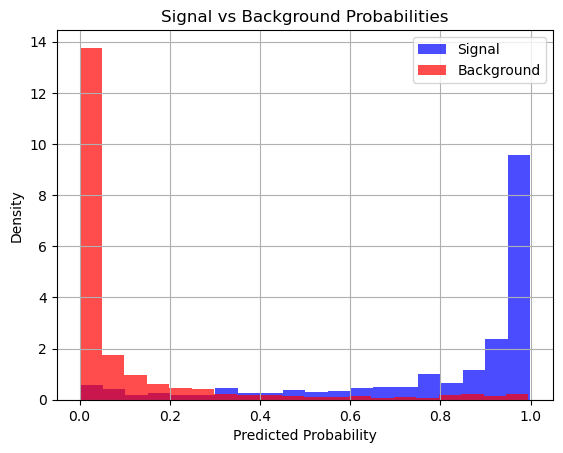

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.9045, Precision: 0.8576, Recall: 0.8576, F1: 0.8576, ROC AUC: 0.9563


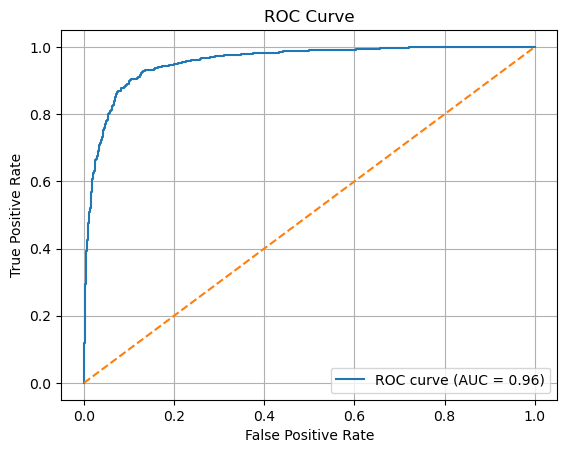

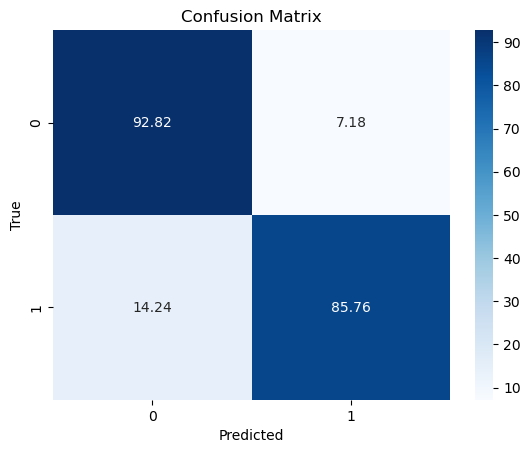

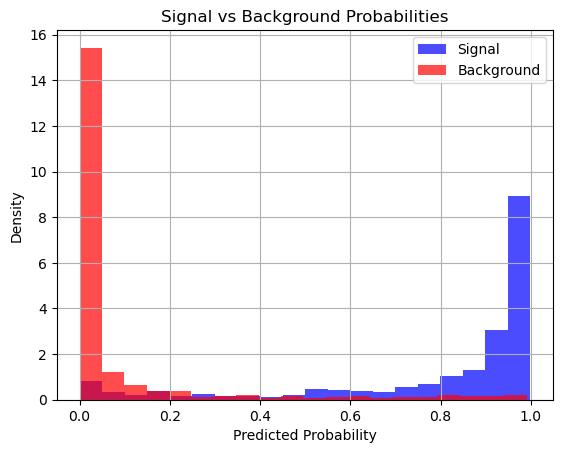

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8999, Precision: 0.8651, Recall: 0.8307, F1: 0.8476, ROC AUC: 0.9535


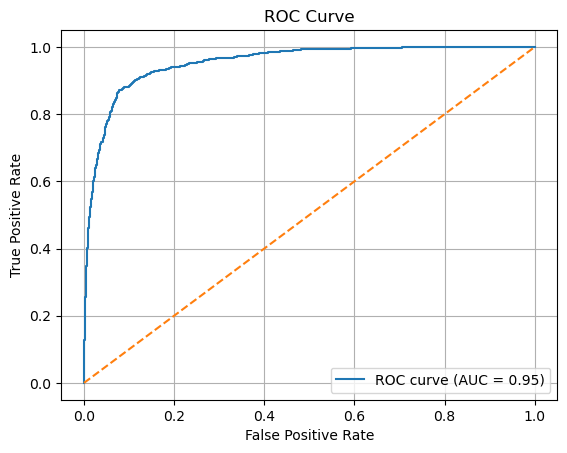

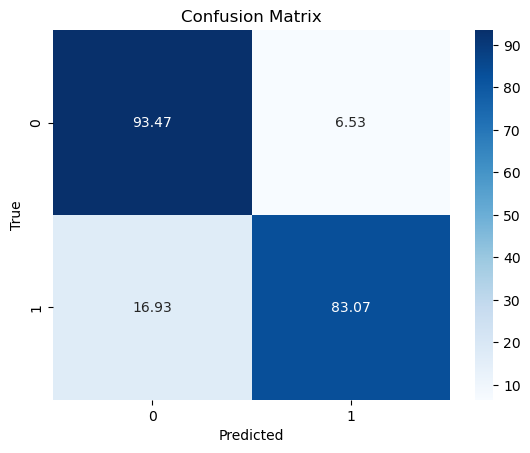

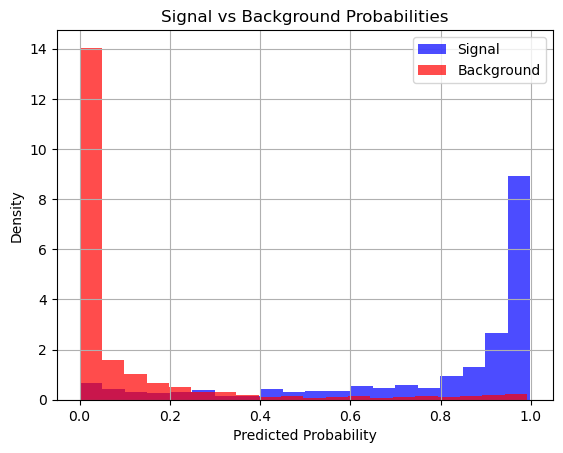

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.9005, Precision: 0.8388, Recall: 0.8705, F1: 0.8543, ROC AUC: 0.9552


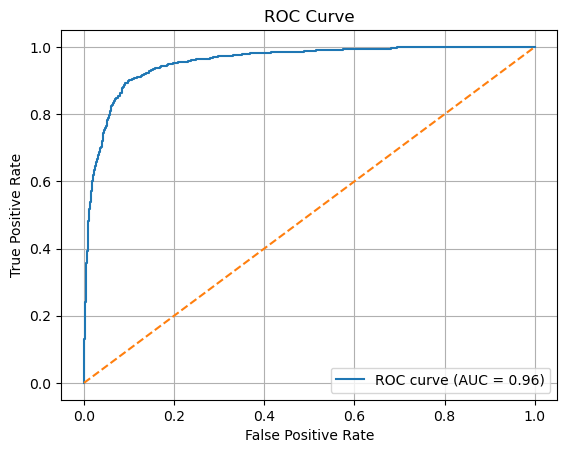

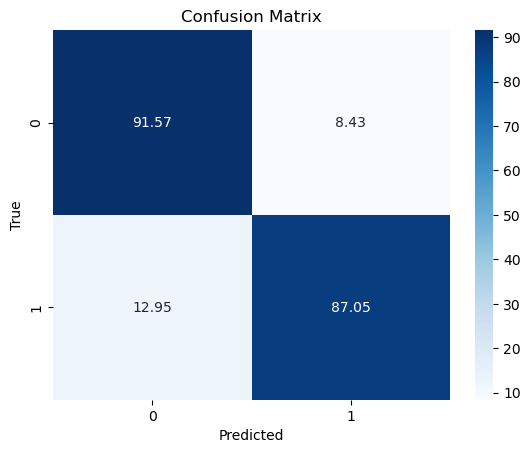

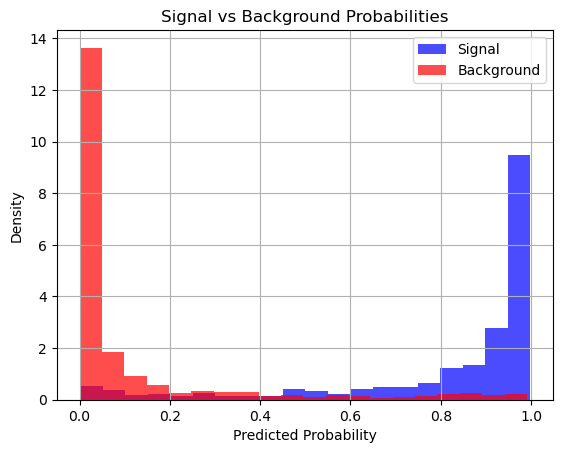

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.9002, Precision: 0.8494, Recall: 0.8536, F1: 0.8515, ROC AUC: 0.9541


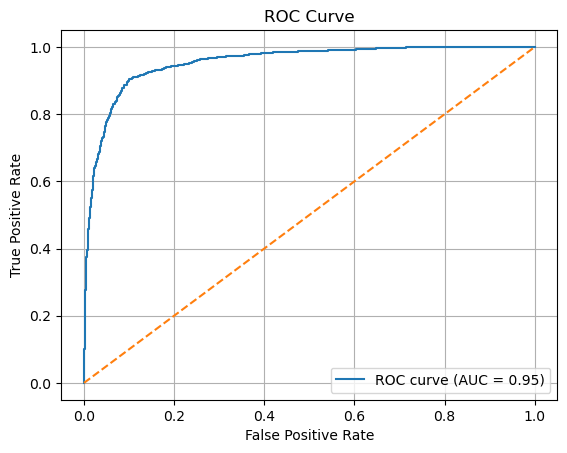

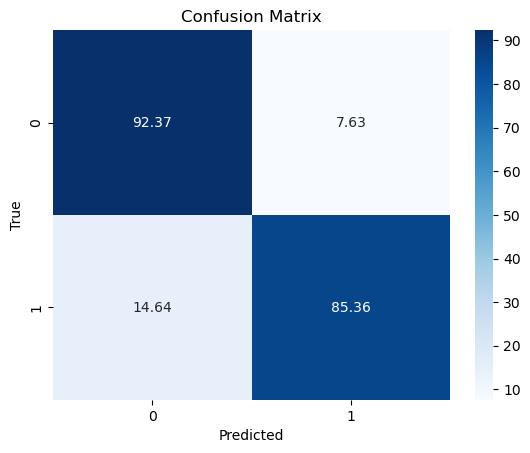

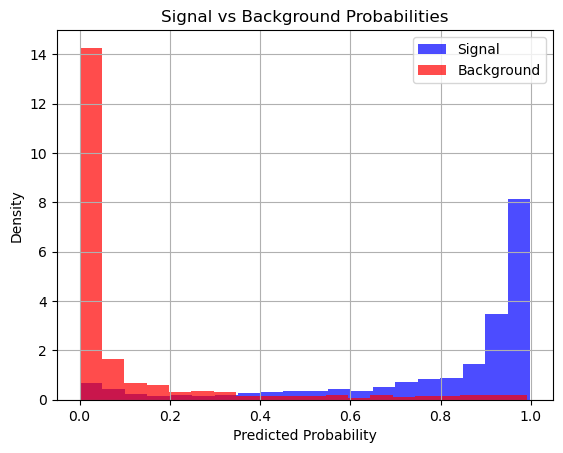

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8992, Precision: 0.8280, Recall: 0.8825, F1: 0.8544, ROC AUC: 0.9554


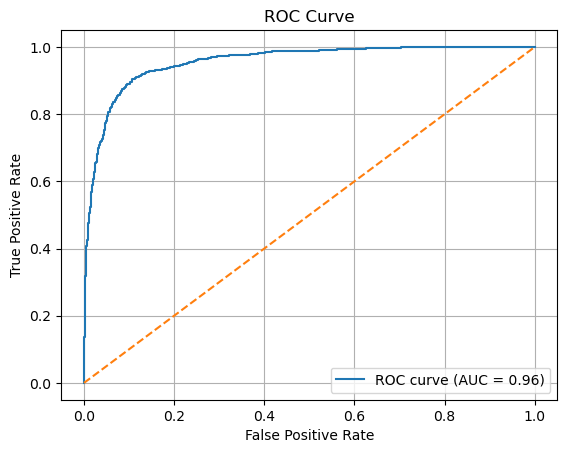

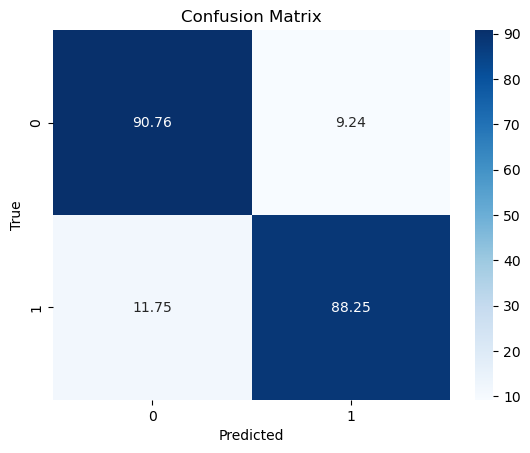

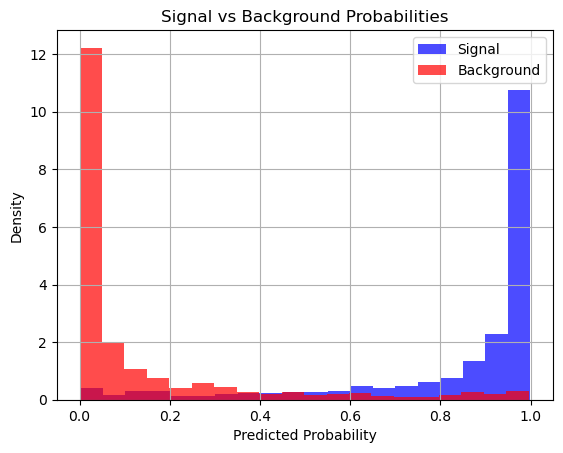

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8748, Precision: 0.7542, Recall: 0.9293, F1: 0.8327, ROC AUC: 0.9547


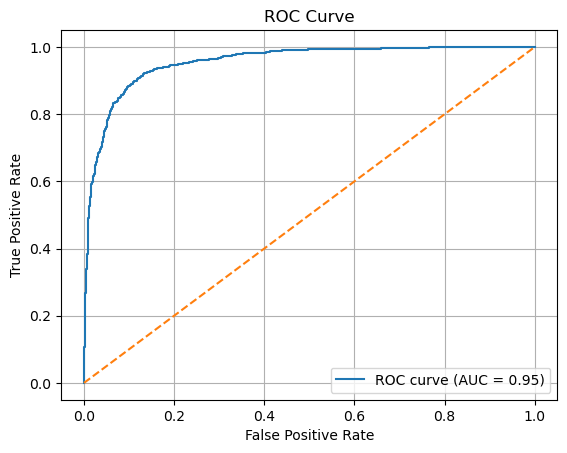

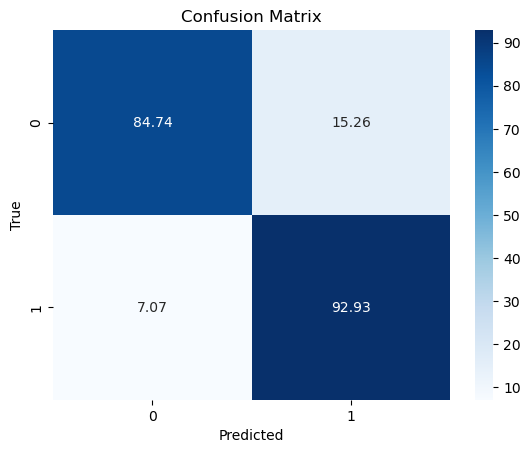

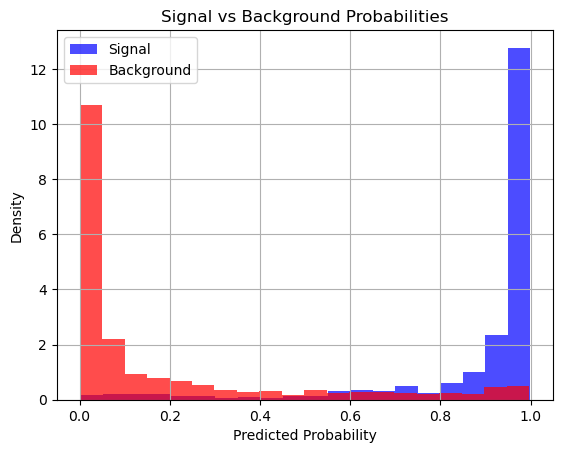

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8972, Precision: 0.8537, Recall: 0.8367, F1: 0.8451, ROC AUC: 0.9560


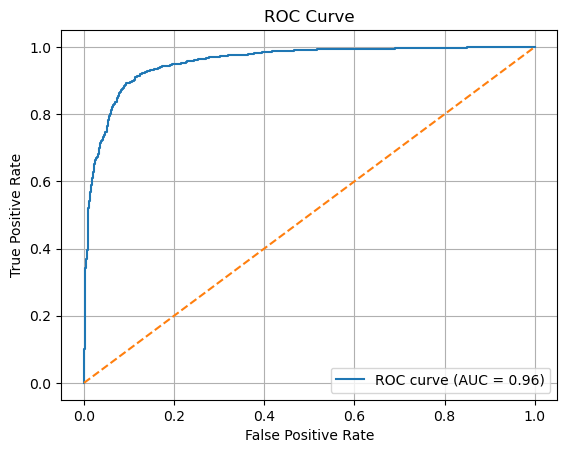

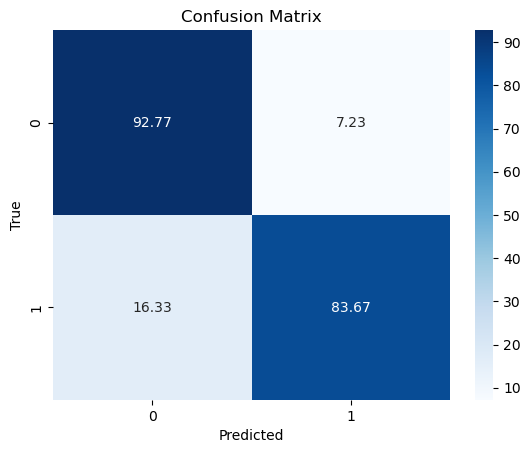

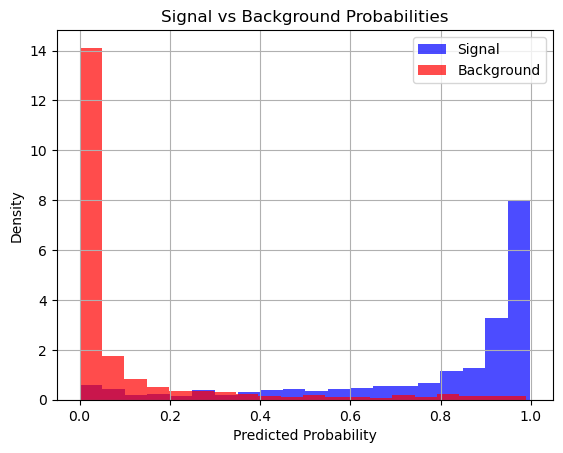

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8985, Precision: 0.8739, Recall: 0.8147, F1: 0.8433, ROC AUC: 0.9532


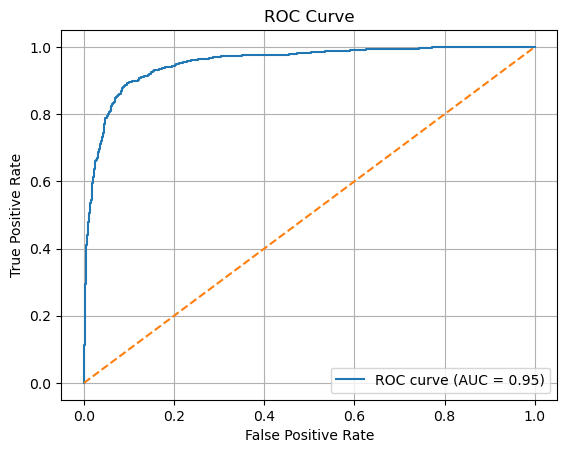

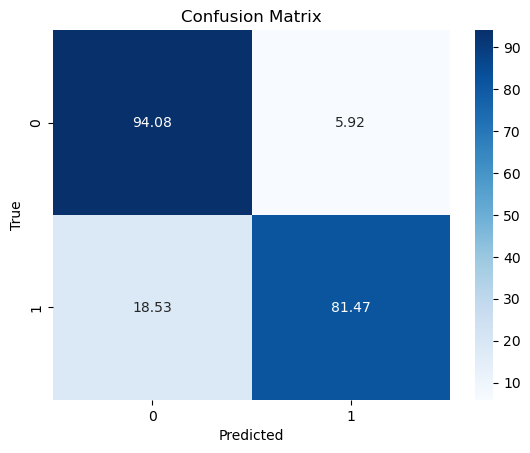

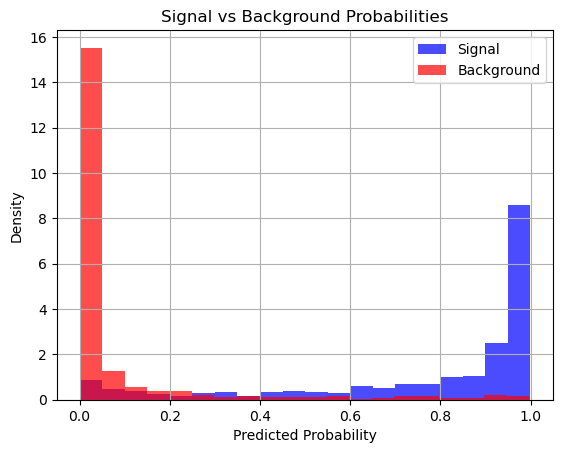

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.9022, Precision: 0.8489, Recall: 0.8616, F1: 0.8552, ROC AUC: 0.9572


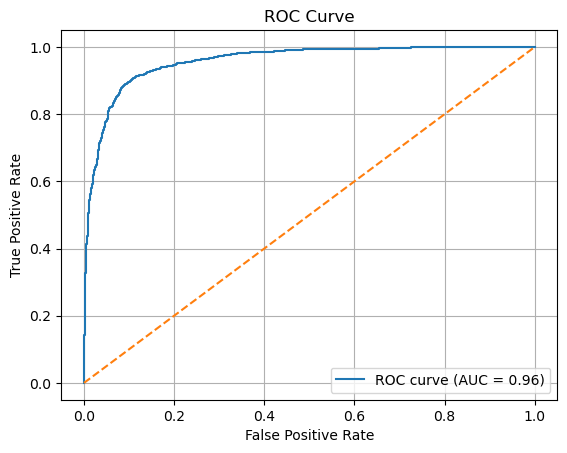

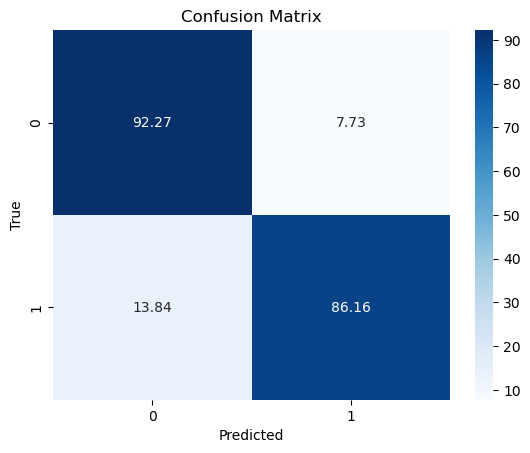

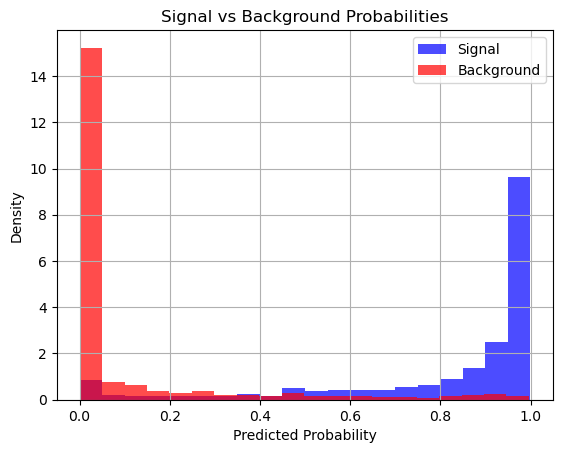

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.9002, Precision: 0.8699, Recall: 0.8257, F1: 0.8472, ROC AUC: 0.9566


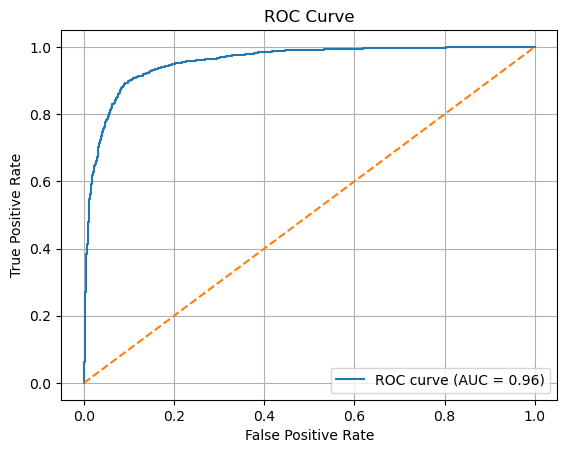

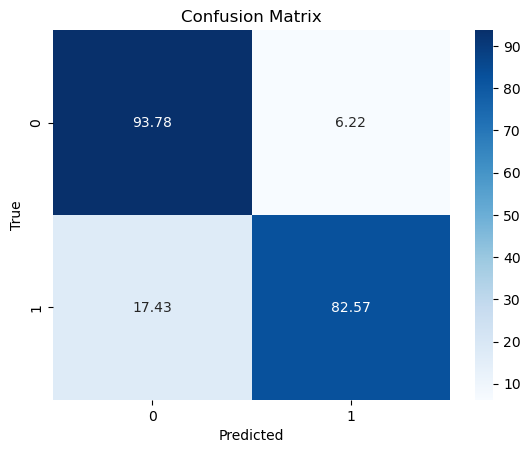

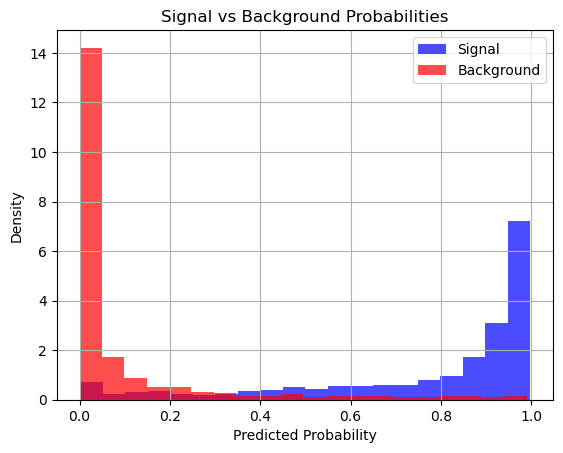

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8885, Precision: 0.7893, Recall: 0.9104, F1: 0.8455, ROC AUC: 0.9538


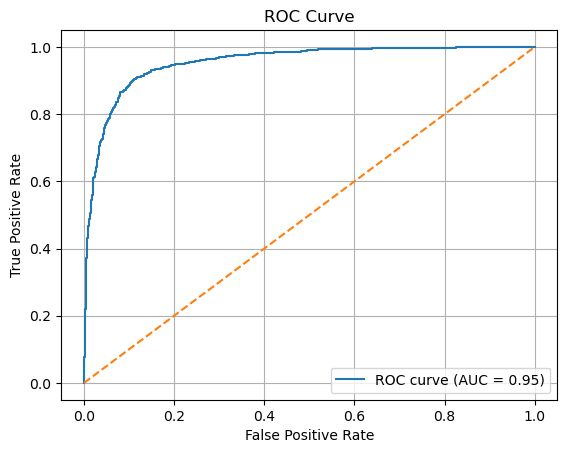

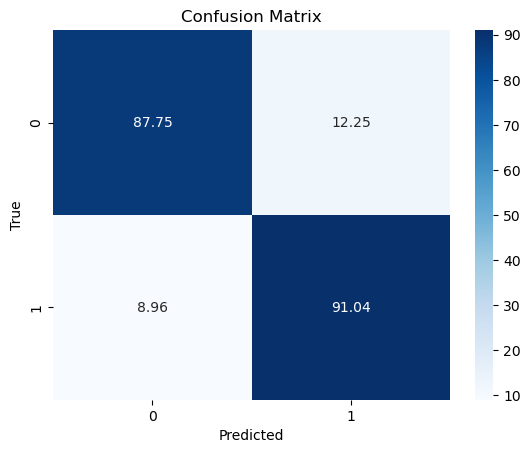

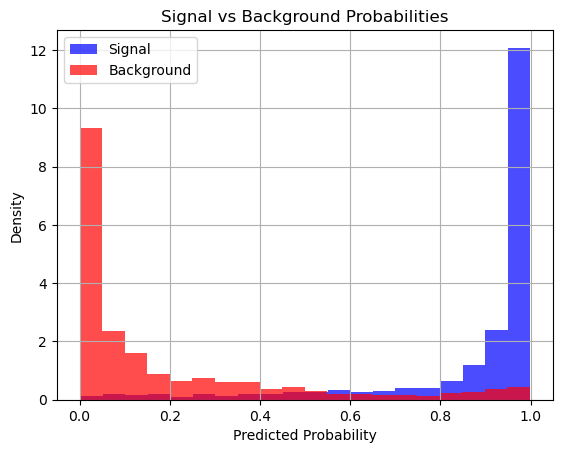

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8879, Precision: 0.7909, Recall: 0.9044, F1: 0.8439, ROC AUC: 0.9559


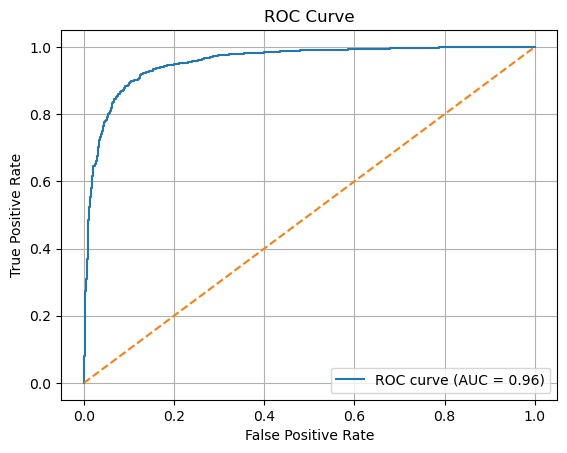

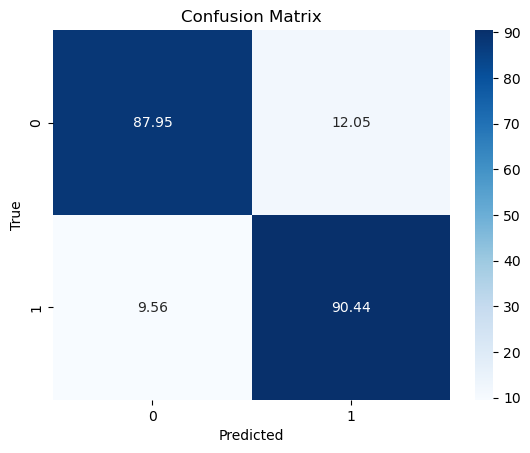

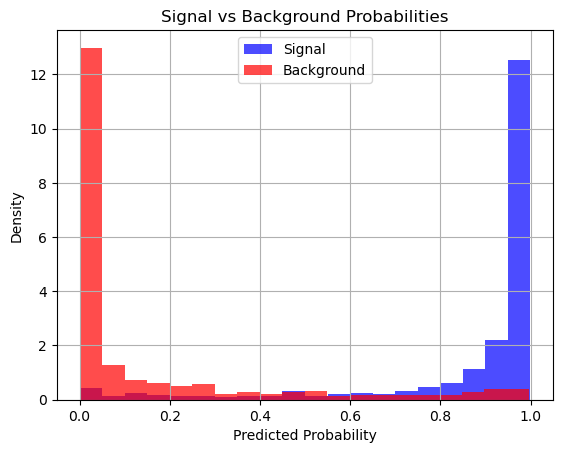

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8939, Precision: 0.8837, Recall: 0.7869, F1: 0.8325, ROC AUC: 0.9558


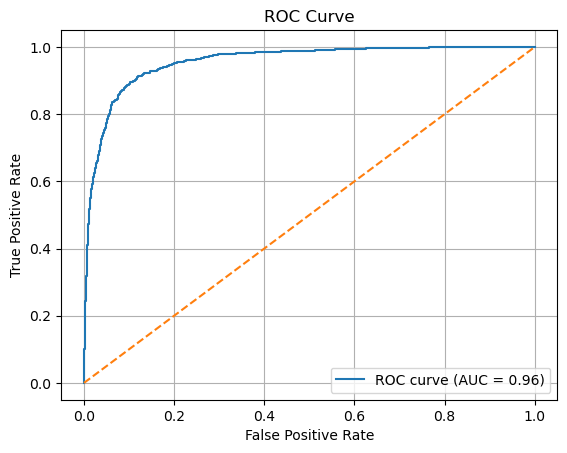

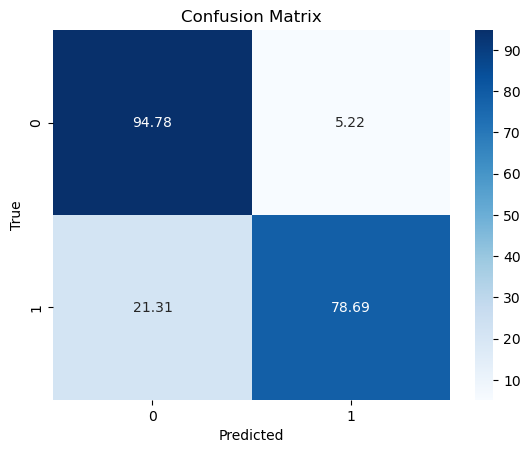

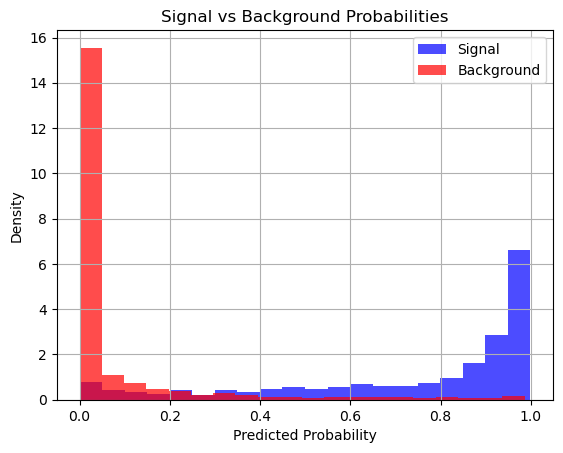

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8995, Precision: 0.8554, Recall: 0.8426, F1: 0.8490, ROC AUC: 0.9534


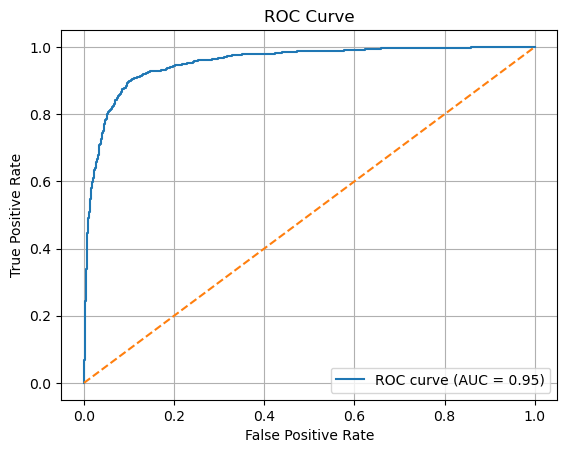

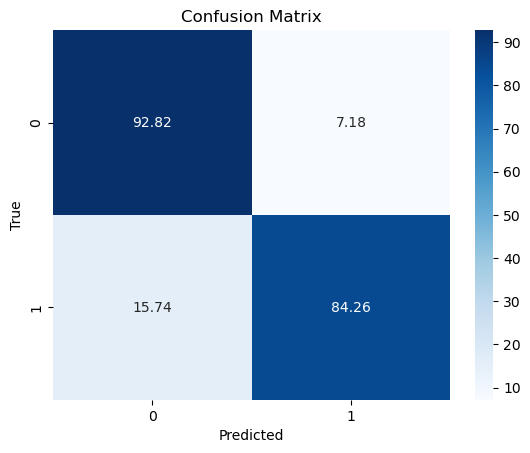

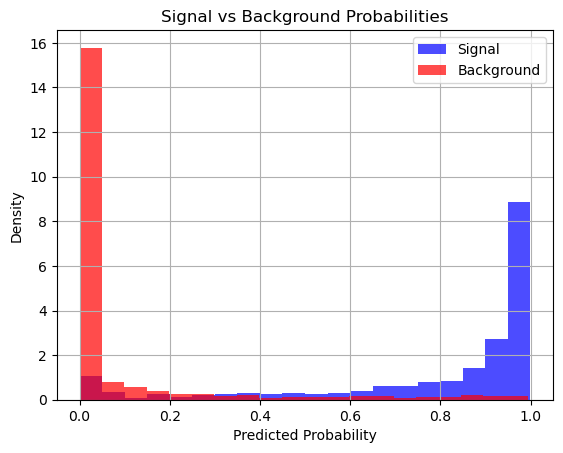

Validation: |          | 0/? [00:00<?, ?it/s]

Accuracy: 0.8989, Precision: 0.8530, Recall: 0.8436, F1: 0.8483, ROC AUC: 0.9542


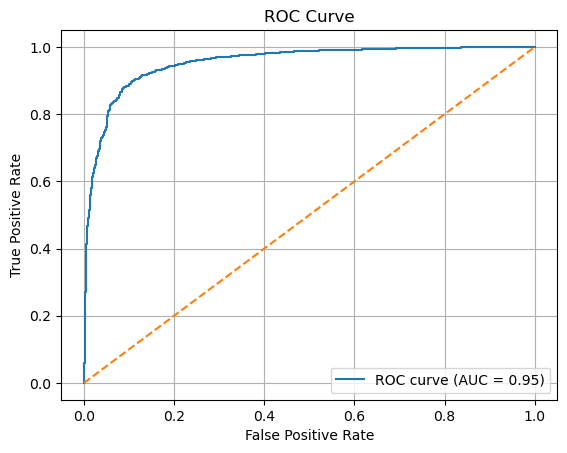

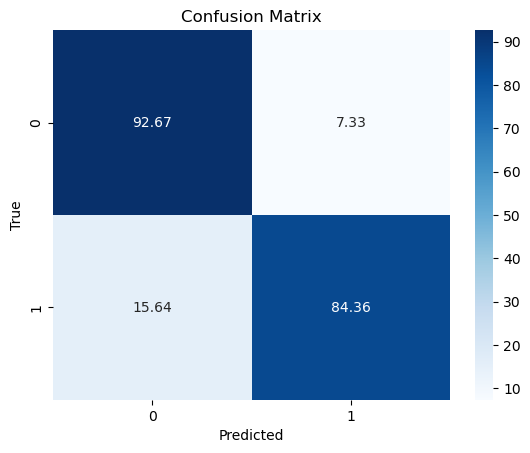

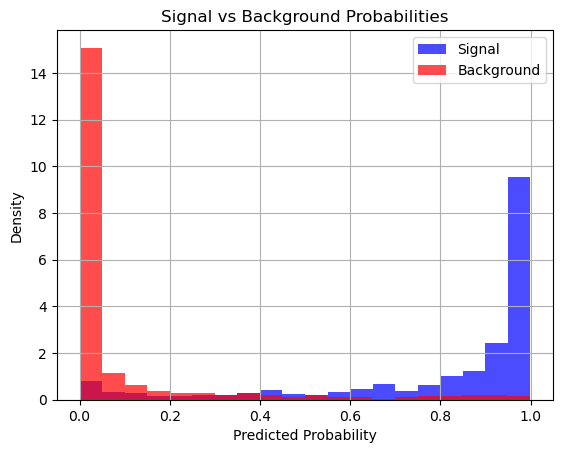

`Trainer.fit` stopped: `max_epochs=30` reached.


In [7]:

# Train the model
model = HyPERModel()
trainer = Trainer(max_epochs=30, accelerator='auto', logger=logger)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

